In [1]:
'''
Date: 24/Jan/2022
Auther: Yike Xie
Content: Figure 5 in dengue paper
'''

'\nDate: 24/Jan/2022\nAuther: Yike Xie\nContent: Figure 5 in dengue paper\n'

In [2]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *    

[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]

In [3]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules') 
import YK_util, optimized_pair_comparison, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison import *
from functions_CCC_figure_fra_pair import *

In [4]:
# load data
path = '/home/yike/phd/dengue/data/mergedata_20211001.h5ad'
adata = sc.read_h5ad(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p = 2
adata_kid = removegenes(adata_kid)
adata_kid = adata_kid[(adata_kid.obs.cell_subtype_new != 'doublets') & 
                        (adata_kid.obs.cell_subtype_new != 'unknown')].copy()

sc.pp.filter_genes(adata_kid, min_cells=3)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [5]:
#rename and reorder some celltypes 
adata_kid = adata_kid.copy()
reorg_celltype(adata_kid) # 'cell_type_new', 'cell_subtype_new'

In [6]:
#save path
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/figure_5/'
save_tables = '/home/yike/phd/dengue/docs/paper_draft/tabels/'

In [7]:
# get cell types and cell subtypes
cell_types = adata_kid.obs['cell_type_new'].unique().tolist()
cell_subtypes = adata_kid.obs['cell_subtype_new'].unique().tolist()

In [8]:
# load cell type palette
ct_palette = load_ct_palette()
print([ct for ct in ct_palette.keys()])
sns.color_palette(ct_palette.values())

['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'Monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [9]:
# load cell subtype palette
cst_palette = load_cst_palette()
print([cst for cst in cst_palette.keys()])
sns.color_palette(cst_palette.values())

['memory B cells', 'naive B cells', 'activated B cells', 'proliferating plasmablasts', 'non-proliferating plasmablasts', 'CD4+ T cells', 'CD8+ effector T cells', 'CD8+ naive/memory T cells', 'signaling NK cells', 'cytotoxic NK cells', 'classical monocytes', 'non-classical monocytes', 'intermediate monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(1.0, 0.0, 0.0),
 (0.7372549019607844, 0.5607843137254902, 0.5607843137254902),
 (0.5019607843137255, 0.0, 0.0),
 (1.0, 0.8941176470588236, 0.7686274509803922),
 (1.0, 0.5490196078431373, 0.0),
 (0.6901960784313725, 0.7686274509803922, 0.8705882352941177),
 (0.2549019607843137, 0.4117647058823529, 0.8823529411764706),
 (0.0, 0.0, 0.5019607843137255),
 (0.5019607843137255, 0.0, 0.5019607843137255),
 (0.8666666666666667, 0.6274509803921569, 0.8666666666666667),
 (0.5607843137254902, 0.7372549019607844, 0.5607843137254902),
 (0.5647058823529412, 0.9333333333333333, 0.5647058823529412),
 (0.0, 0.5019607843137255, 0.0),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [58]:
def heatmap_cst(cst_pair, g_list, cst_order, vs_type='SD vs D', save_fd=False):
    #rcParams['figure.figsize']=(7, 14)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    
    df = cst_pair.reset_index().set_index('gene').loc[g_list][['cell_subtype', 'med_pair']]

    df_new = pd.DataFrame(np.zeros([len(df.index.unique()), len(cst_order)]), columns=cst_order, index=g_list)

    for idx in df_new.index:    
        for col in df_new.columns:
            df_new.at[idx, col] = df.loc[idx][df.loc[idx]['cell_subtype'] == col]['med_pair'][0]

    fig, ax = plt.subplots(figsize=[1 + 1.5 * len(cst_order), 0.5 * len(g_list)])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    ax = sns.heatmap(df_new, cmap=cmap, center=0, yticklabels=True, 
                     cbar_kws={'label': 'log2 fold change\n[%s]'%vs_type, 'shrink': .3})
    ax.set_ylabel(None)
    
    xlabels = [label.get_text().replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels)

    if save_fd is not False:
        fig.savefig(save_figures + save_fd, bbox_inches='tight')

    return {'figure': fig, 'ax': ax}

def pairwise_boxplot(FCs_data, cell_subtype, genes, path=False):
    
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    box_data = FCs_data.loc[cell_subtype][genes]
    
    cmap = mpl.cm.get_cmap('coolwarm')
    norm = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
    palette = [cmap(norm(x)) for x in np.clip(box_data.median(axis=0), -2.5, 2.5)]
    
    box_data = pd.melt(box_data)
    
    fig, ax = plt.subplots(figsize=(6, len(genes)*0.35 + 1))
    sns.boxplot(data = box_data, y = 'variable', x = 'value', palette = palette, width=0.8,
                orient = 'h', linewidth=1, ax=ax)
    
    ax.set(ylabel = None, xlim = (-12, 12))
    ax.set_yticklabels(genes)
    
    ax.set_xlabel('log2 fold change')
    
    ax_cb = fig.add_axes([0.25, 0, 0.5, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks([-2, -1, 0, 1, 2])
    cbar.set_ticklabels(['-2', '-1', '0', '1', '2'])
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('log2 fold change', fontsize=15)

    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    if path is not False:
        fig.savefig(save_figures + path, bbox_inches='tight')
        
    return {'figure': fig, 'ax': ax}

def annanote_adult(adata_adult): 
    adata_adult.obs['cell_type_new'] = adata_adult.obs['cell_type']
    adata_adult.obs['cell_type_new'] = adata_adult.obs['cell_type_new'].astype('object')
    adata_adult.obs['cell_subtype_new'] = adata_adult.obs['cell_subtype_new'].astype('object')
    
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'NK_cells', 'cell_type_new'] = 'NK cells'
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'B_cells', 'cell_type_new'] = 'B cells'
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'T_cells', 'cell_type_new'] = 'T cells'
    ####################################
    
    for gene in ['GZMA',  'NKG7', 'GNLY', 'XCL1', 'XCL2', 'FCGR3A', 'CCND2', 'MKI67']:
            adata_adult.obs[gene] = (adata_adult[:, gene].X.toarray() > 0)
    
    ####################  
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'NK cells', 'cell_type_new'] = 'NK_unknown'
    idx_NK = ((adata_adult.obs['cell_type_new'] == 'NK_unknown') &
             (adata_adult.obs['GZMA'] == True) &
             (adata_adult.obs['NKG7'] == True) &
             (adata_adult.obs['GNLY'] == True) )
    adata_adult.obs.loc[idx_NK, 'cell_type_new'] = 'NK cells'
    
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'NK cells', 'cell_subtype_new'] = 'cytotoxic NK cells'
    idx_sig_NK = ((adata_adult.obs['cell_type_new'] == 'NK cells') & 
                        (adata_adult.obs['XCL1'] == True) & 
                        (adata_adult.obs['XCL2'] == True) &
                        (adata_adult.obs['FCGR3A'] == True))
    adata_adult.obs.loc[idx_sig_NK, 'cell_subtype_new'] = 'signaling NK cells'
    
    ####################
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'Plasmablasts', 'cell_subtype_new'] = 'non-proliferating plasmablasts'
    idx_P = ((adata_adult.obs['cell_type_new'] == 'Plasmablasts') & 
                        (adata_adult.obs['CCND2'] == True) & 
                        (adata_adult.obs['MKI67'] == True))
    adata_adult.obs.loc[idx_P, 
                        'cell_subtype_new'] = 'proliferating plasmablasts'
    
    ####################
    adata_adult.obs['cell_type_new'] = adata_adult.obs['cell_type_new'].astype('category')
    adata_adult.obs['cell_subtype_new'] = adata_adult.obs['cell_subtype_new'].astype('category')    
    return adata_adult

def pair_comparison(adata, ct_obs, cell_types, gene_cut_off, cell_cut_off, log1p=False):    
    import random
    ress = pd.DataFrame([])
    log2FC = pd.DataFrame([])
    
    cds = ['dengue', 'S_dengue']
    
    for cell_type in cell_types:
        adata_ct = adata[adata.obs[ct_obs] == cell_type]
        
        ####### filter out genes expressed less than gene_cut_off in all patients
        IDs = list(adata_ct.obs['ID'].unique())
        fra = [np.asarray((adata_ct[adata_ct.obs['ID'] == ID].X > 0).mean(axis=0))[0] for ID in IDs]
        fra=pd.DataFrame(fra, index=IDs, columns=adata_ct.var_names).T
        gene_list = fra.index.tolist()
        
        if gene_cut_off is not False:
            for idx, row in fra.iterrows():
                n = 0
                for i in row.tolist():
                    if i <= gene_cut_off:
                        n += 1
                if n == len(IDs):
                    gene_list.remove(idx)
        
        adata_ct = adata_ct[:, gene_list]
        
        ####### filter out patient with less than 5 cells for the cell type
        if ct_obs == 'cell_type_new':
            ct = cell_type
        elif ct_obs == 'cell_subtype_new':
            ct = adata_ct.obs['cell_type_new'].unique()[0]
        
        for ID in IDs:
            if adata[(adata.obs['cell_type_new'] == ct) & (adata.obs['ID'] == ID)].obs.shape[0] < cell_cut_off:
                IDs.remove(ID)
        adata_ct = adata_ct[adata_ct.obs['ID'].isin(IDs)]
        
        adata_S_ct = adata_ct[adata_ct.obs['Condition'] == cds[1]]
        adata_NS_ct = adata_ct[adata_ct.obs['Condition'] == cds[0]]
        
        IDs_S = list(adata_S_ct.obs['ID'].unique())
        IDs_NS = list(adata_NS_ct.obs['ID'].unique())
                
        ####### pair comparison
        log2_fc = []
        for ID_S in IDs_S:
            adata_S_ID = adata_S_ct[adata_S_ct.obs['ID'] == ID_S]
            
            for ID_NS in IDs_NS:
                adata_NS_ID = adata_NS_ct[adata_NS_ct.obs['ID'] == ID_NS]

                X_S = adata_S_ID.X
                X_NS = adata_NS_ID.X
                avg_S = np.asarray(X_S.mean(axis=0))[0]
                avg_NS = np.asarray(X_NS.mean(axis=0))[0]

                if log1p is False:
                    log2_fc.append(np.log2(avg_S + 1) - np.log2(avg_NS + 1))
                elif log1p not in (True, 2):
                    log2_fc.append((avg_S - avg_NS) / np.log2(log1p))
                else:
                    log2_fc.append(avg_S - avg_NS)

        log2_fc = np.asarray(log2_fc)
        
        if log2_fc.size == 0:
            continue
        med_pair = np.median(log2_fc, axis=0)
        fra_pair = [len(log2_fc[:, i][log2_fc[:, i] > 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]
        neg_fra_pair = [len(log2_fc[:, i][log2_fc[:, i] < 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]

        res = pd.DataFrame([], index=adata_ct.var_names)
        res['med_pair'] = med_pair
        res['fra_pair'] = fra_pair
        res['neg_fra_pair'] = neg_fra_pair
        res['cell_subtype'] = cell_type
        ress = pd.concat([ress, res], join='outer')
        ress['gene'] = ress.index.tolist()

        FCs = pd.DataFrame(log2_fc, columns = adata_ct.var_names, index=[cell_type] * log2_fc.shape[0])
        log2FC = pd.concat([log2FC, FCs], join='outer')
        
    return {'pair_res': ress, 'log_FCs': log2FC}

In [11]:
ct_pair = pd.read_csv(save_tables + 'ct_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
ct_log2FC = pd.read_csv(save_tables + 'ct_log2FC.tsv', sep='\t', index_col=0)

cst_pair = pd.read_csv(save_tables + 'cst_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
cst_log2FC = pd.read_csv(save_tables + 'cst_log2FC.tsv', sep='\t', index_col=0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


{'figure': <Figure size 1200x5850 with 2 Axes>, 'ax': <AxesSubplot:>}

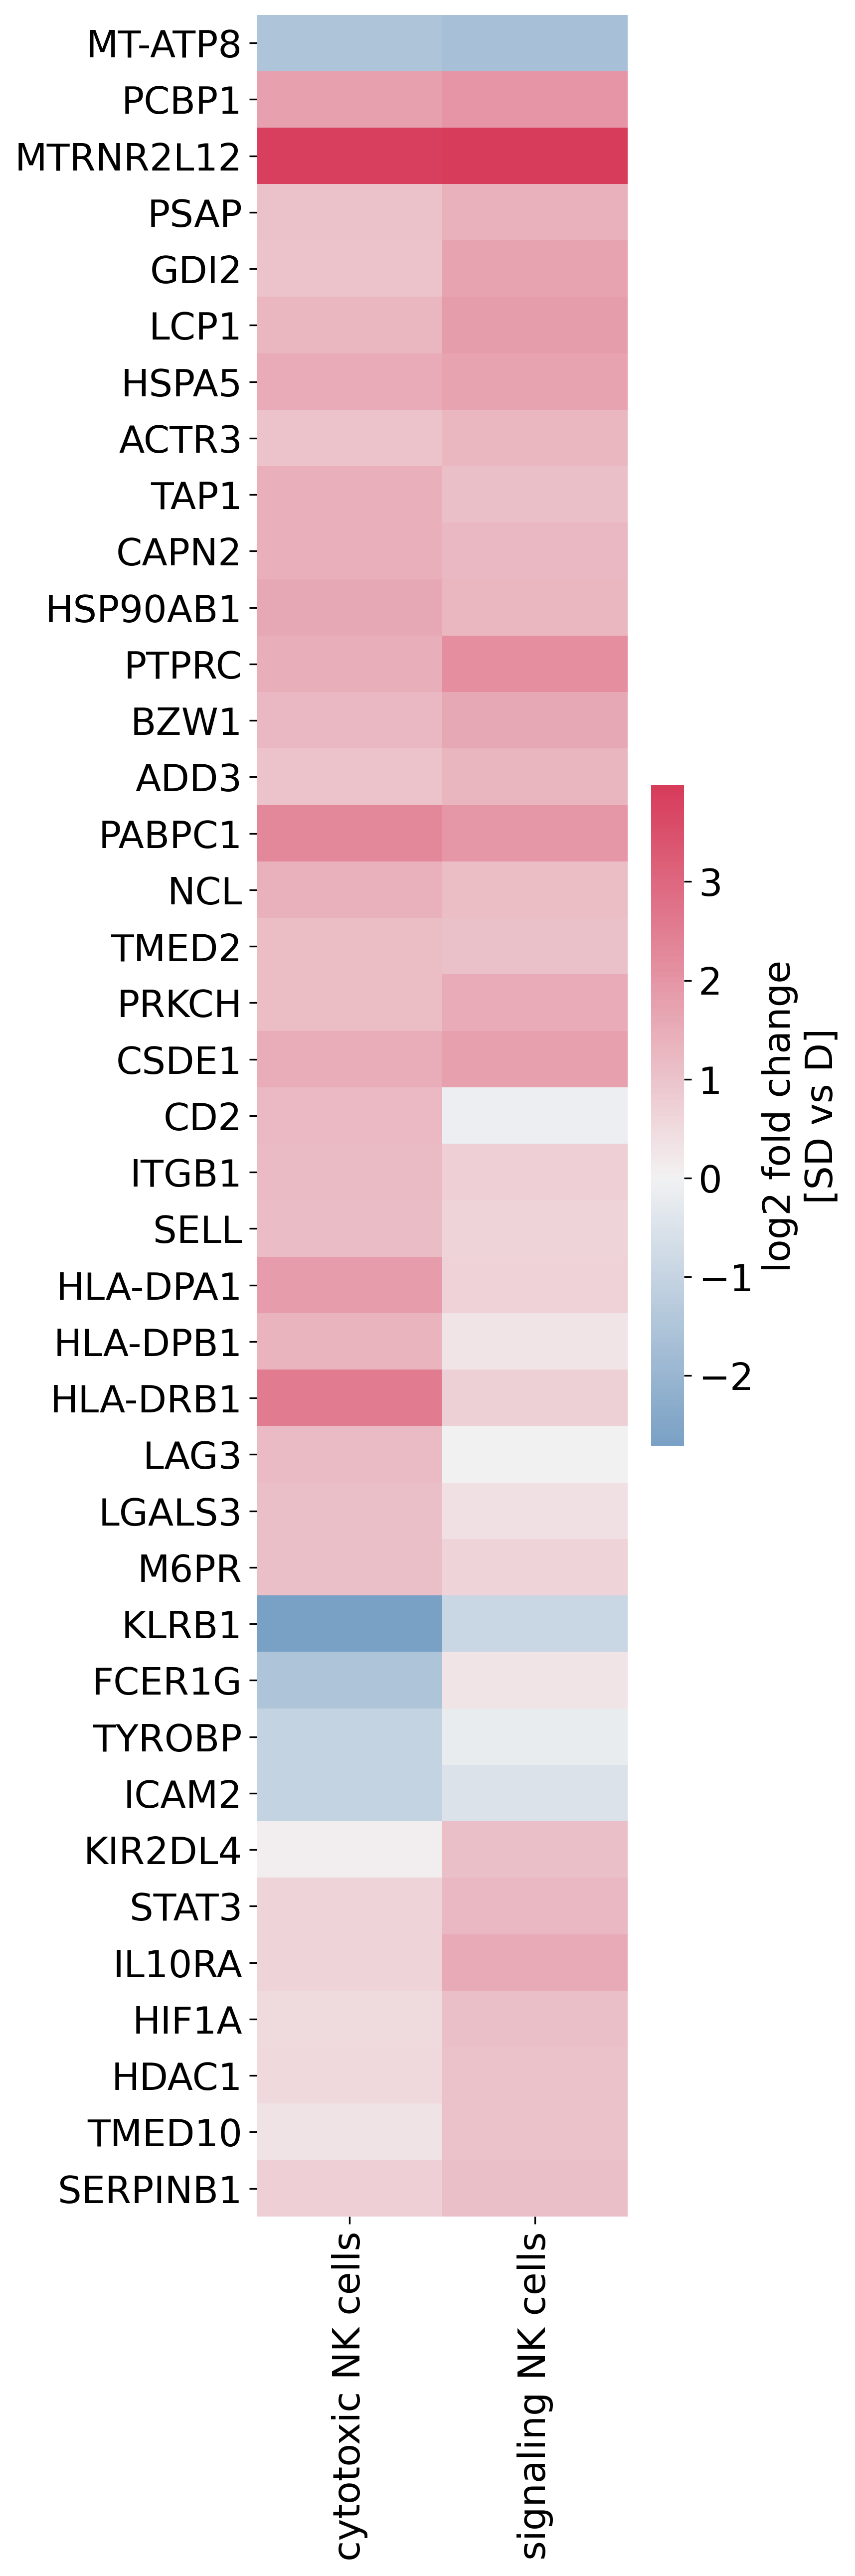

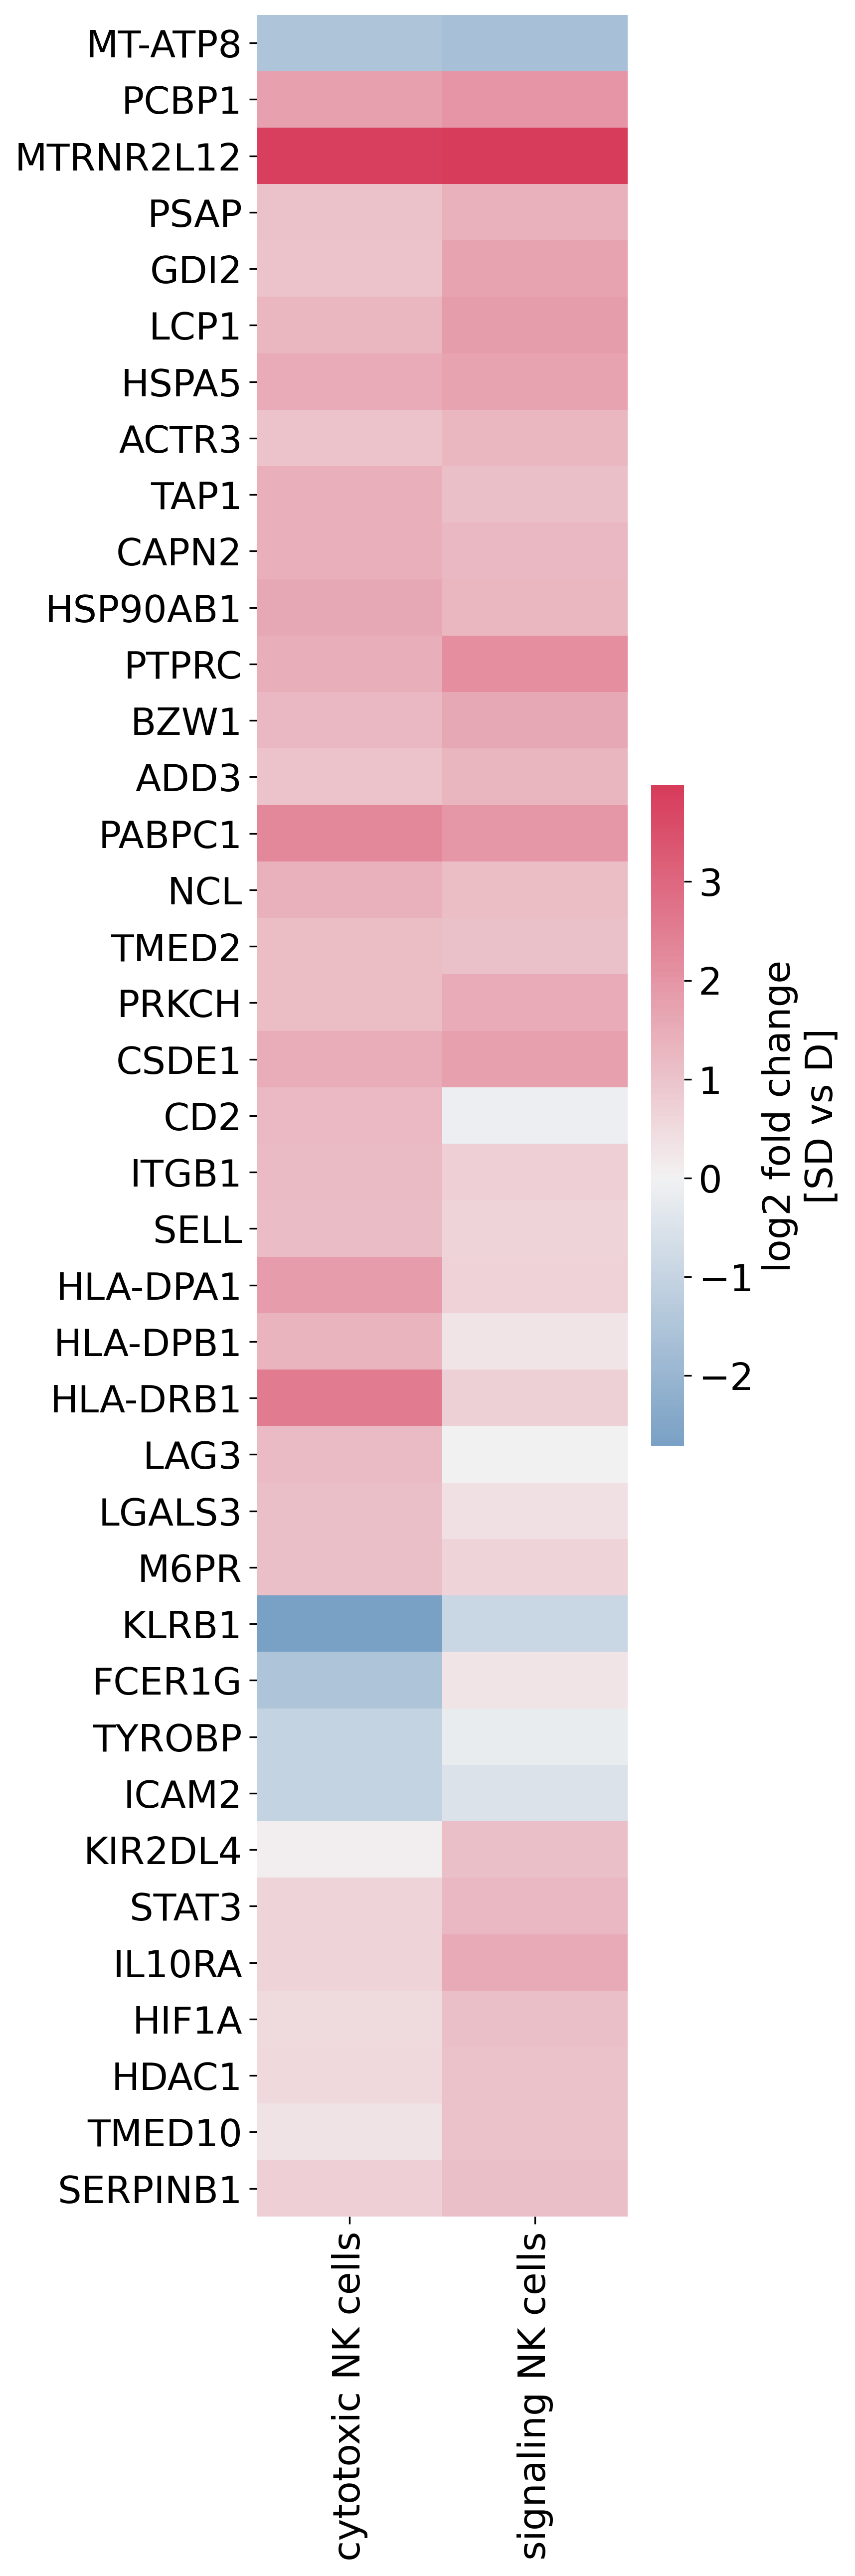

In [12]:
glist = [
'MT-ATP8', 'PCBP1', 'MTRNR2L12', 'PSAP', 'GDI2', 
    'LCP1', 'HSPA5', 'ACTR3', 'TAP1', 'CAPN2', 'HSP90AB1', 'PTPRC', 
    'BZW1', 'ADD3', 'PABPC1', 'NCL', 'TMED2', 'PRKCH', 'CSDE1', 'CD2', 'ITGB1', 
    'SELL', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DRB1', 'LAG3', 'LGALS3', 'M6PR', 'KLRB1', 'FCER1G', 
    'TYROBP', 'ICAM2', 'KIR2DL4', 'STAT3', 'IL10RA', 'HIF1A', 'HDAC1', 'TMED10', 'SERPINB1'
]
heatmap_cst(cst_pair, glist, ['cytotoxic NK cells', 'signaling NK cells'], 
            save_fd='NK_cst_heatmap.pdf')
heatmap_cst(cst_pair, glist, ['cytotoxic NK cells', 'signaling NK cells'], 
            save_fd='NK_cst_heatmap.png')

{'figure': <Figure size 1800x1560 with 2 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change'>}

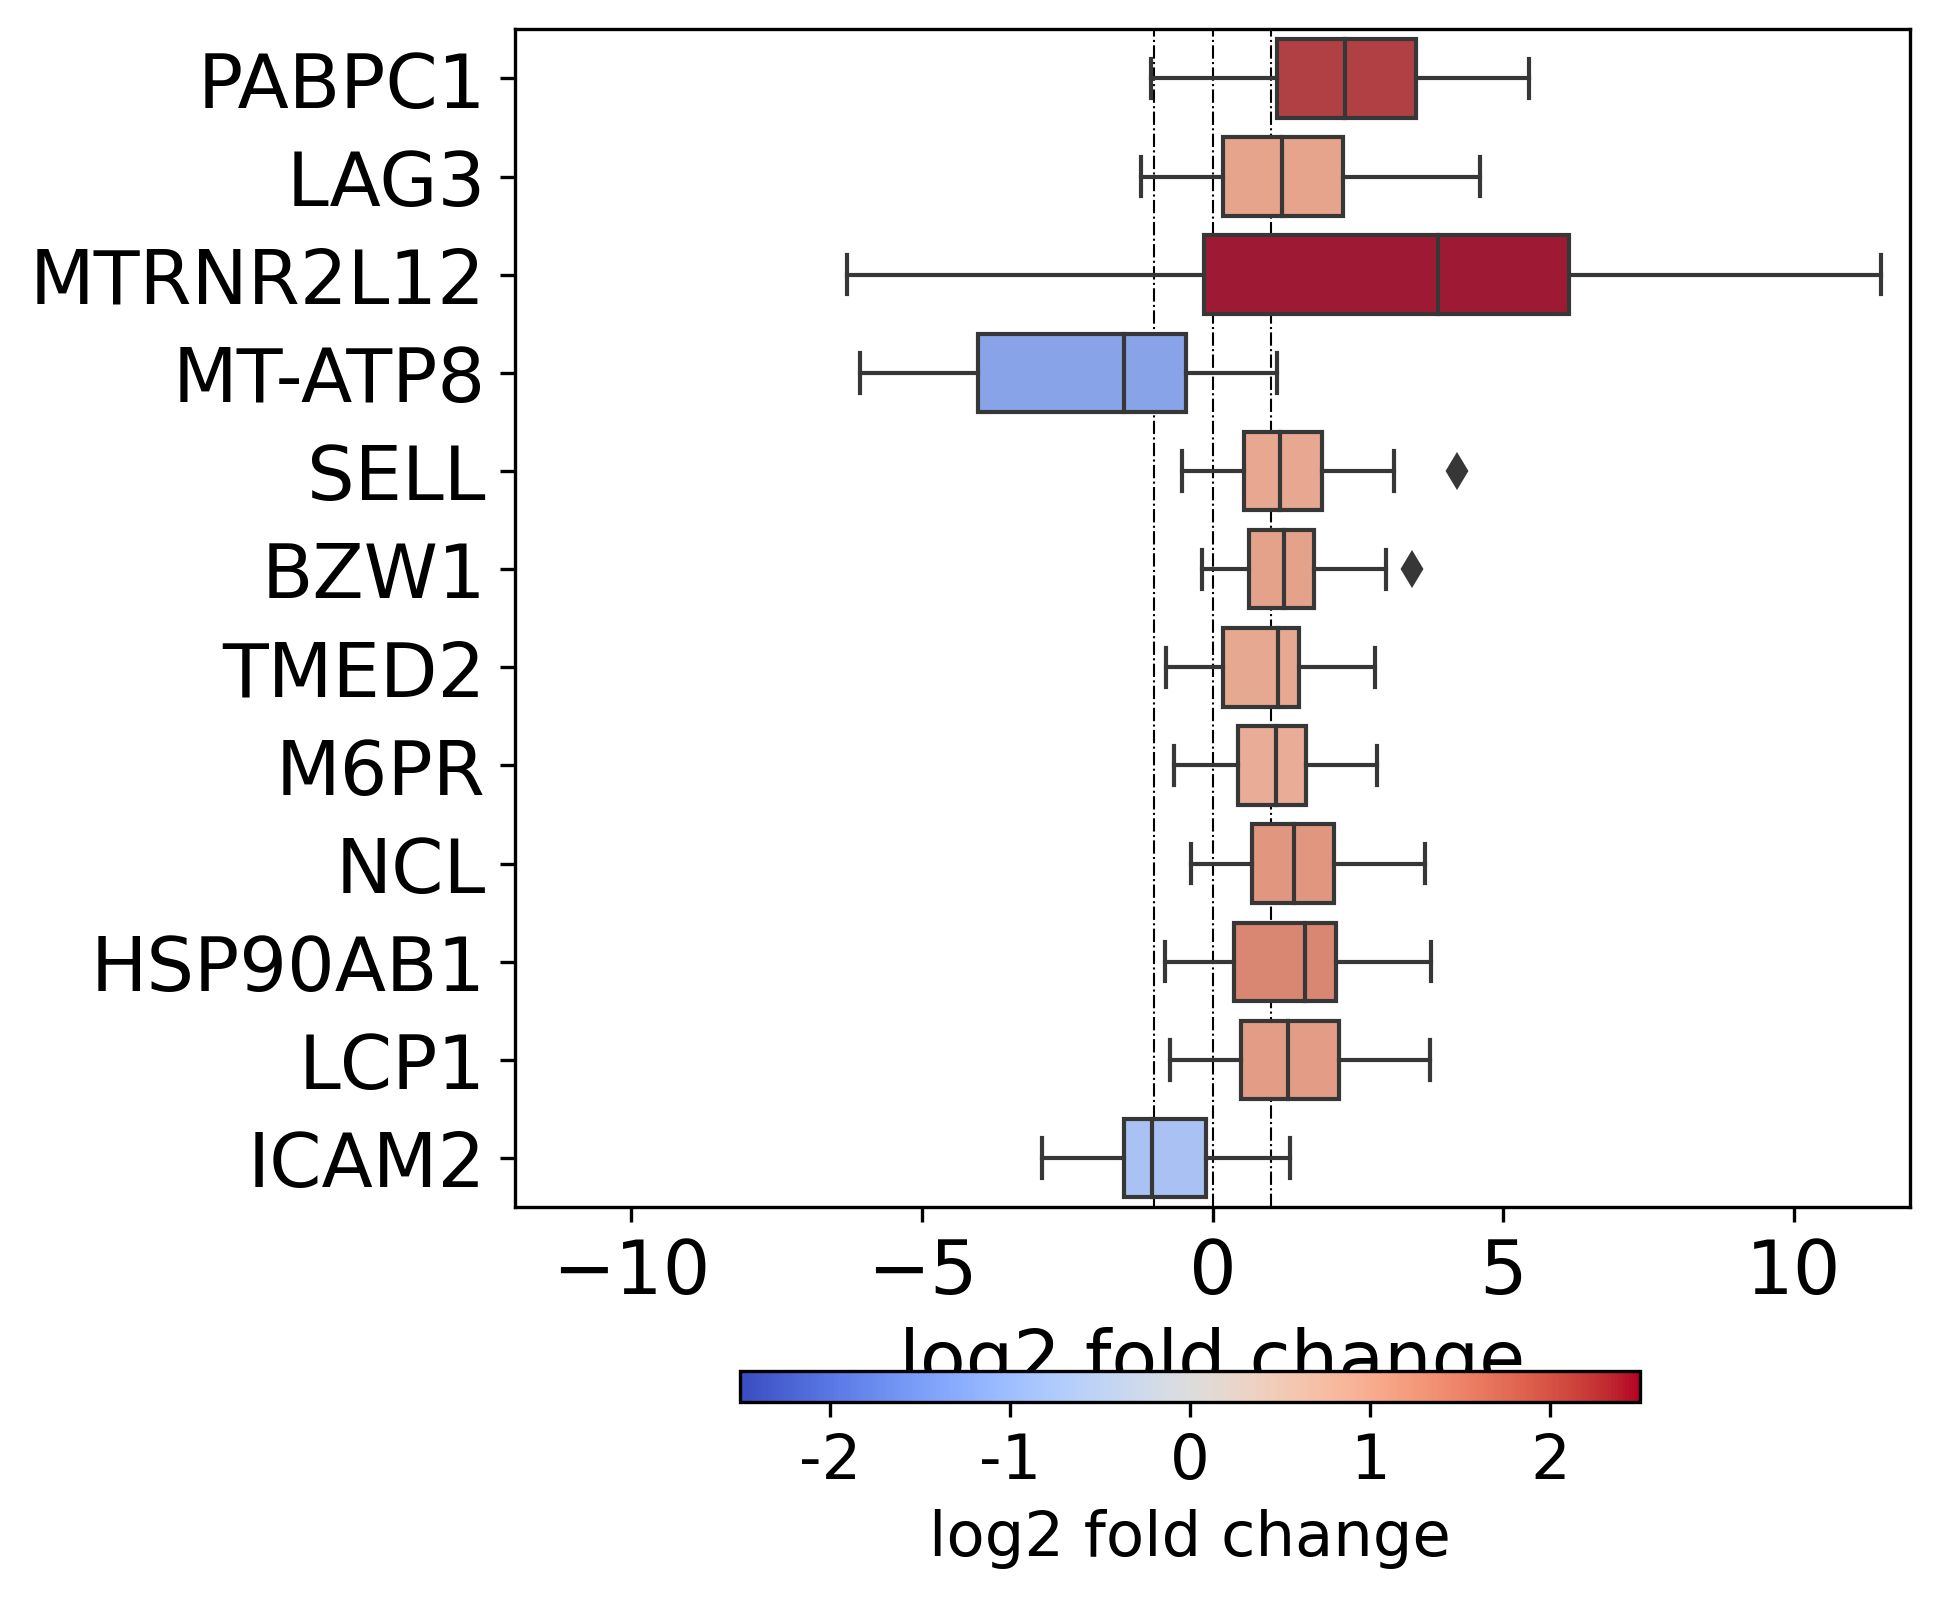

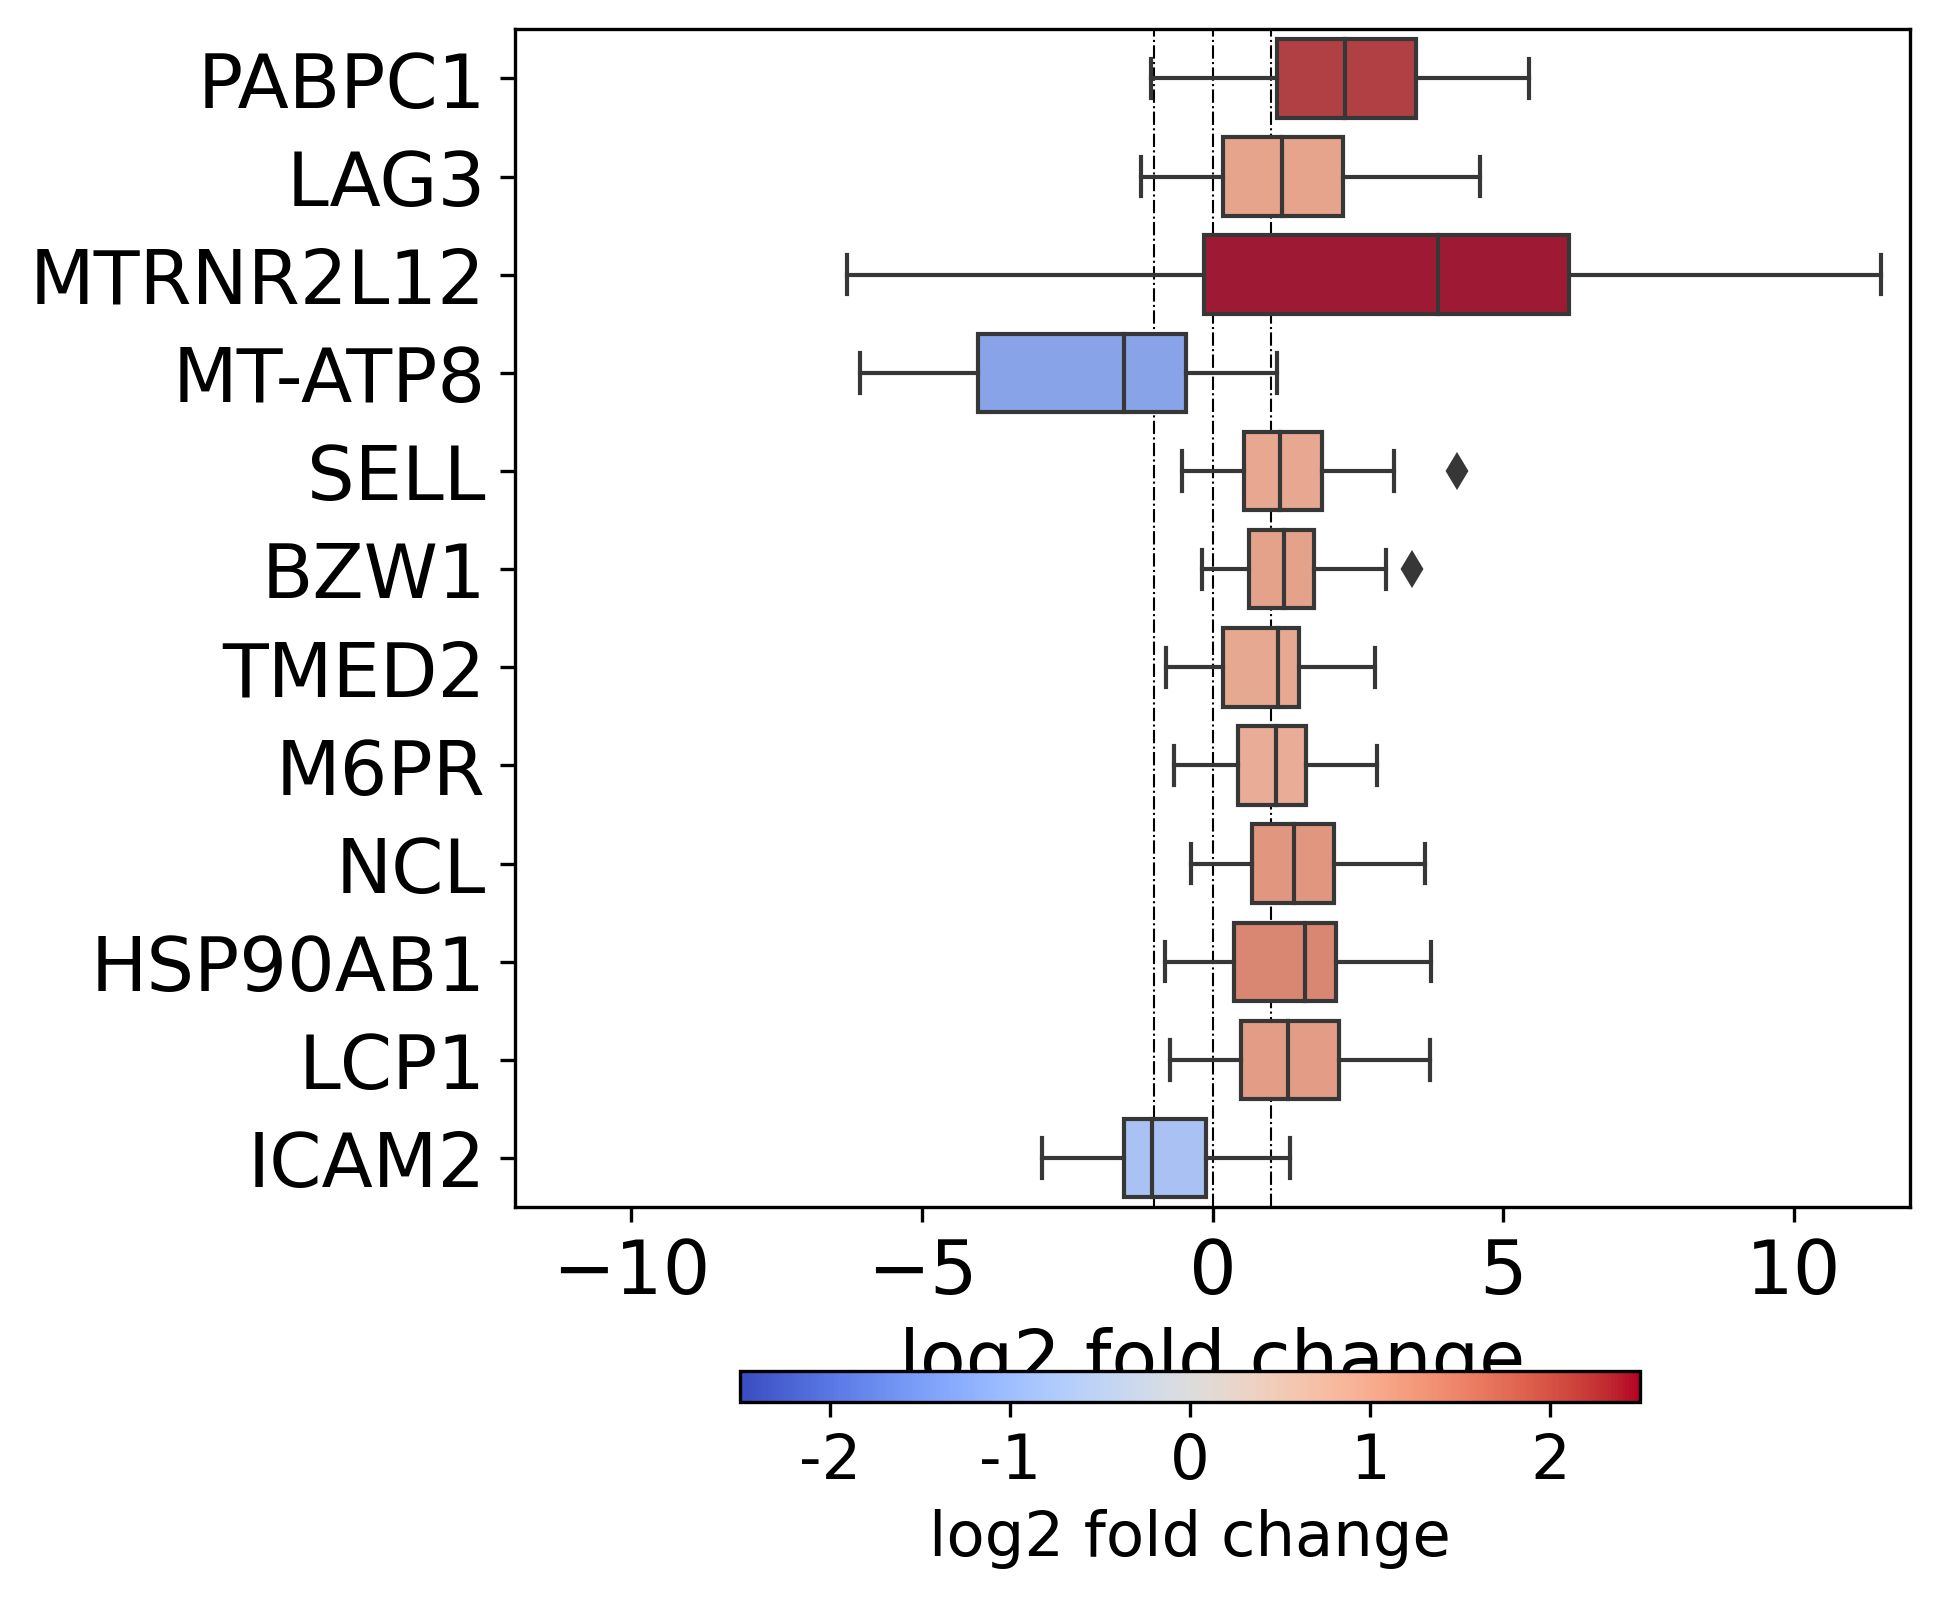

In [20]:
child_genes = [
'PABPC1', 'LAG3', 'MTRNR2L12', 'MT-ATP8', 'SELL',
    'BZW1', 'TMED2', 'M6PR', 'NCL', 'HSP90AB1',
    'LCP1', 'ICAM2'
]
pairwise_boxplot(cst_log2FC, ['cytotoxic NK cells'], child_genes, path='NK_child.pdf')
pairwise_boxplot(cst_log2FC, ['cytotoxic NK cells'], child_genes, path='NK_child.png')

In [22]:
adata_adult = subsetdata(adata, platform ='plate')
adata_adult = normalizedata(adata_adult)
adata_adult = removegenes(adata_adult)

adata_adult = annanote_adult(adata_adult)


csts = ['cytotoxic NK cells', 'signaling NK cells', 'proliferating plasmablasts', 'non-proliferating plasmablasts']
pair = pair_comparison(adata_adult, 'cell_subtype_new', csts, gene_cut_off=0.1, cell_cut_off=5, log1p=2)

pair['pair_res'].to_csv(save_tables + 'adult_cst_pair.tsv', sep='\t', index=False)
pair['log_FCs'].to_csv(save_tables + 'adult_cst_log2FC.tsv', sep='\t')

cts = ['Monocytes', 'NK cells', 'T cells', 'B cells', 'Plasmablasts']
pair = pair_comparison(adata_adult, 'cell_type_new', cts, gene_cut_off=False, cell_cut_off=5, log1p=2)

pair['pair_res'].to_csv(save_tables + 'adult_ct_pair.tsv', sep='\t', index=False)
pair['log_FCs'].to_csv(save_tables + 'adult_ct_log2FC.tsv', sep='\t')

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [56]:
cst_pair_a = pd.read_csv(save_tables + 'adult_cst_pair.tsv', sep='\t', index_col='cell_subtype')
cst_log2FC_a = pd.read_csv(save_tables + 'adult_cst_log2FC.tsv', sep='\t', index_col=0)

ct_pair_a = pd.read_csv(save_tables + 'adult_ct_pair.tsv', sep='\t', index_col='cell_subtype')
ct_log2FC_a = pd.read_csv(save_tables + 'adult_ct_log2FC.tsv', sep='\t', index_col=0)

{'figure': <Figure size 1800x1560 with 2 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change'>}

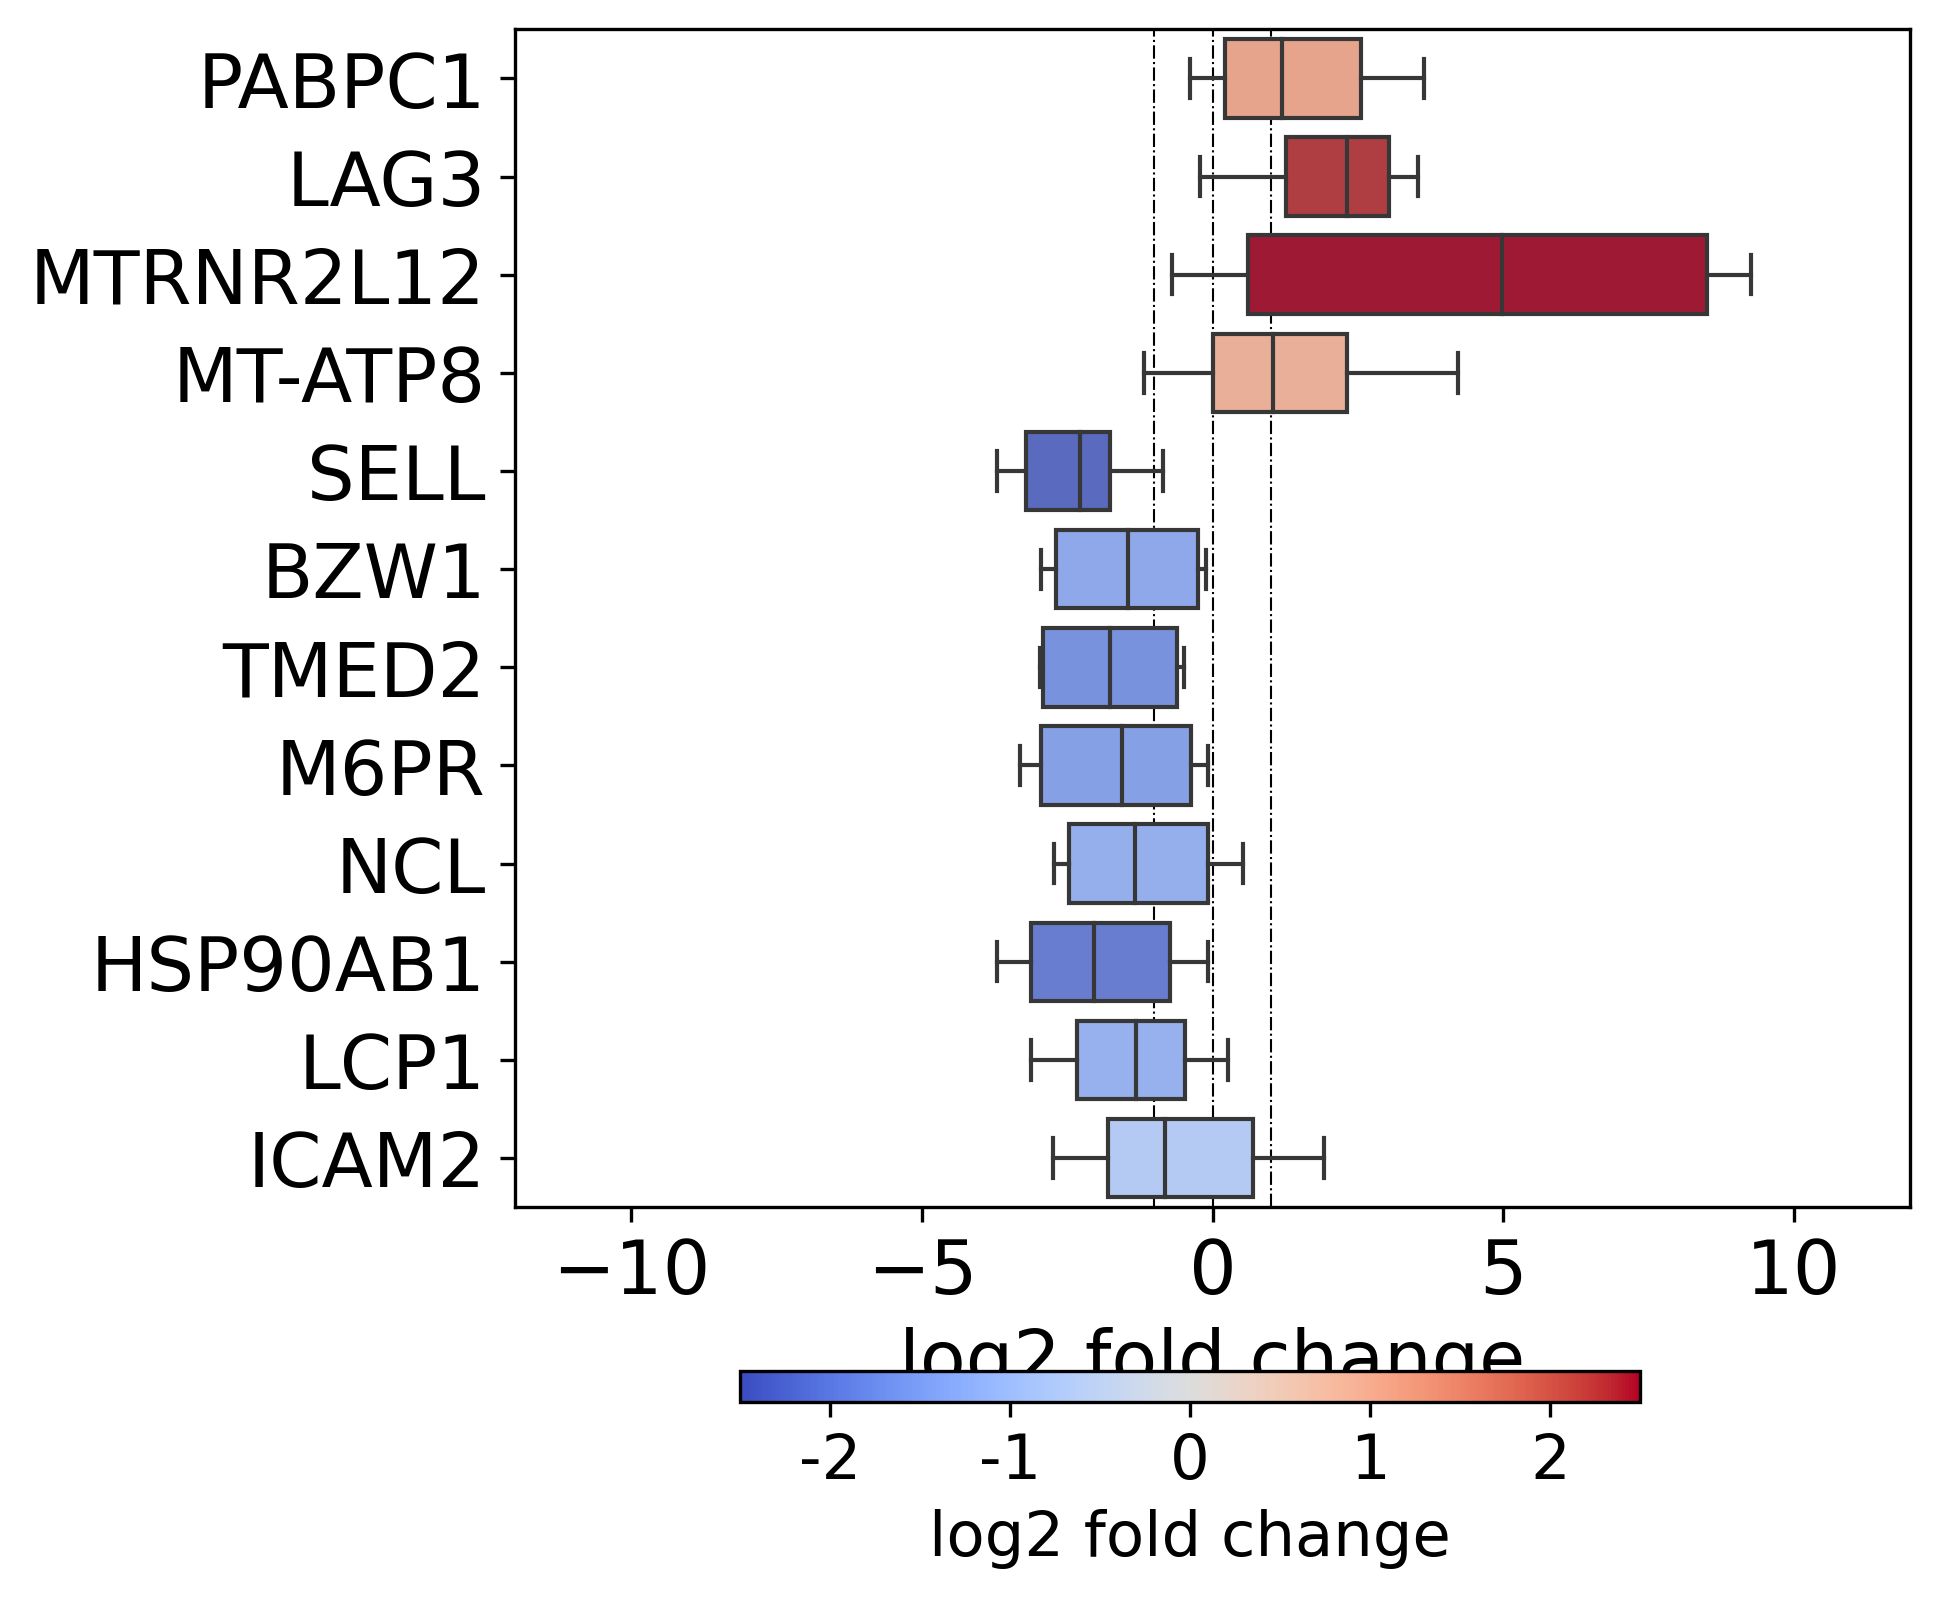

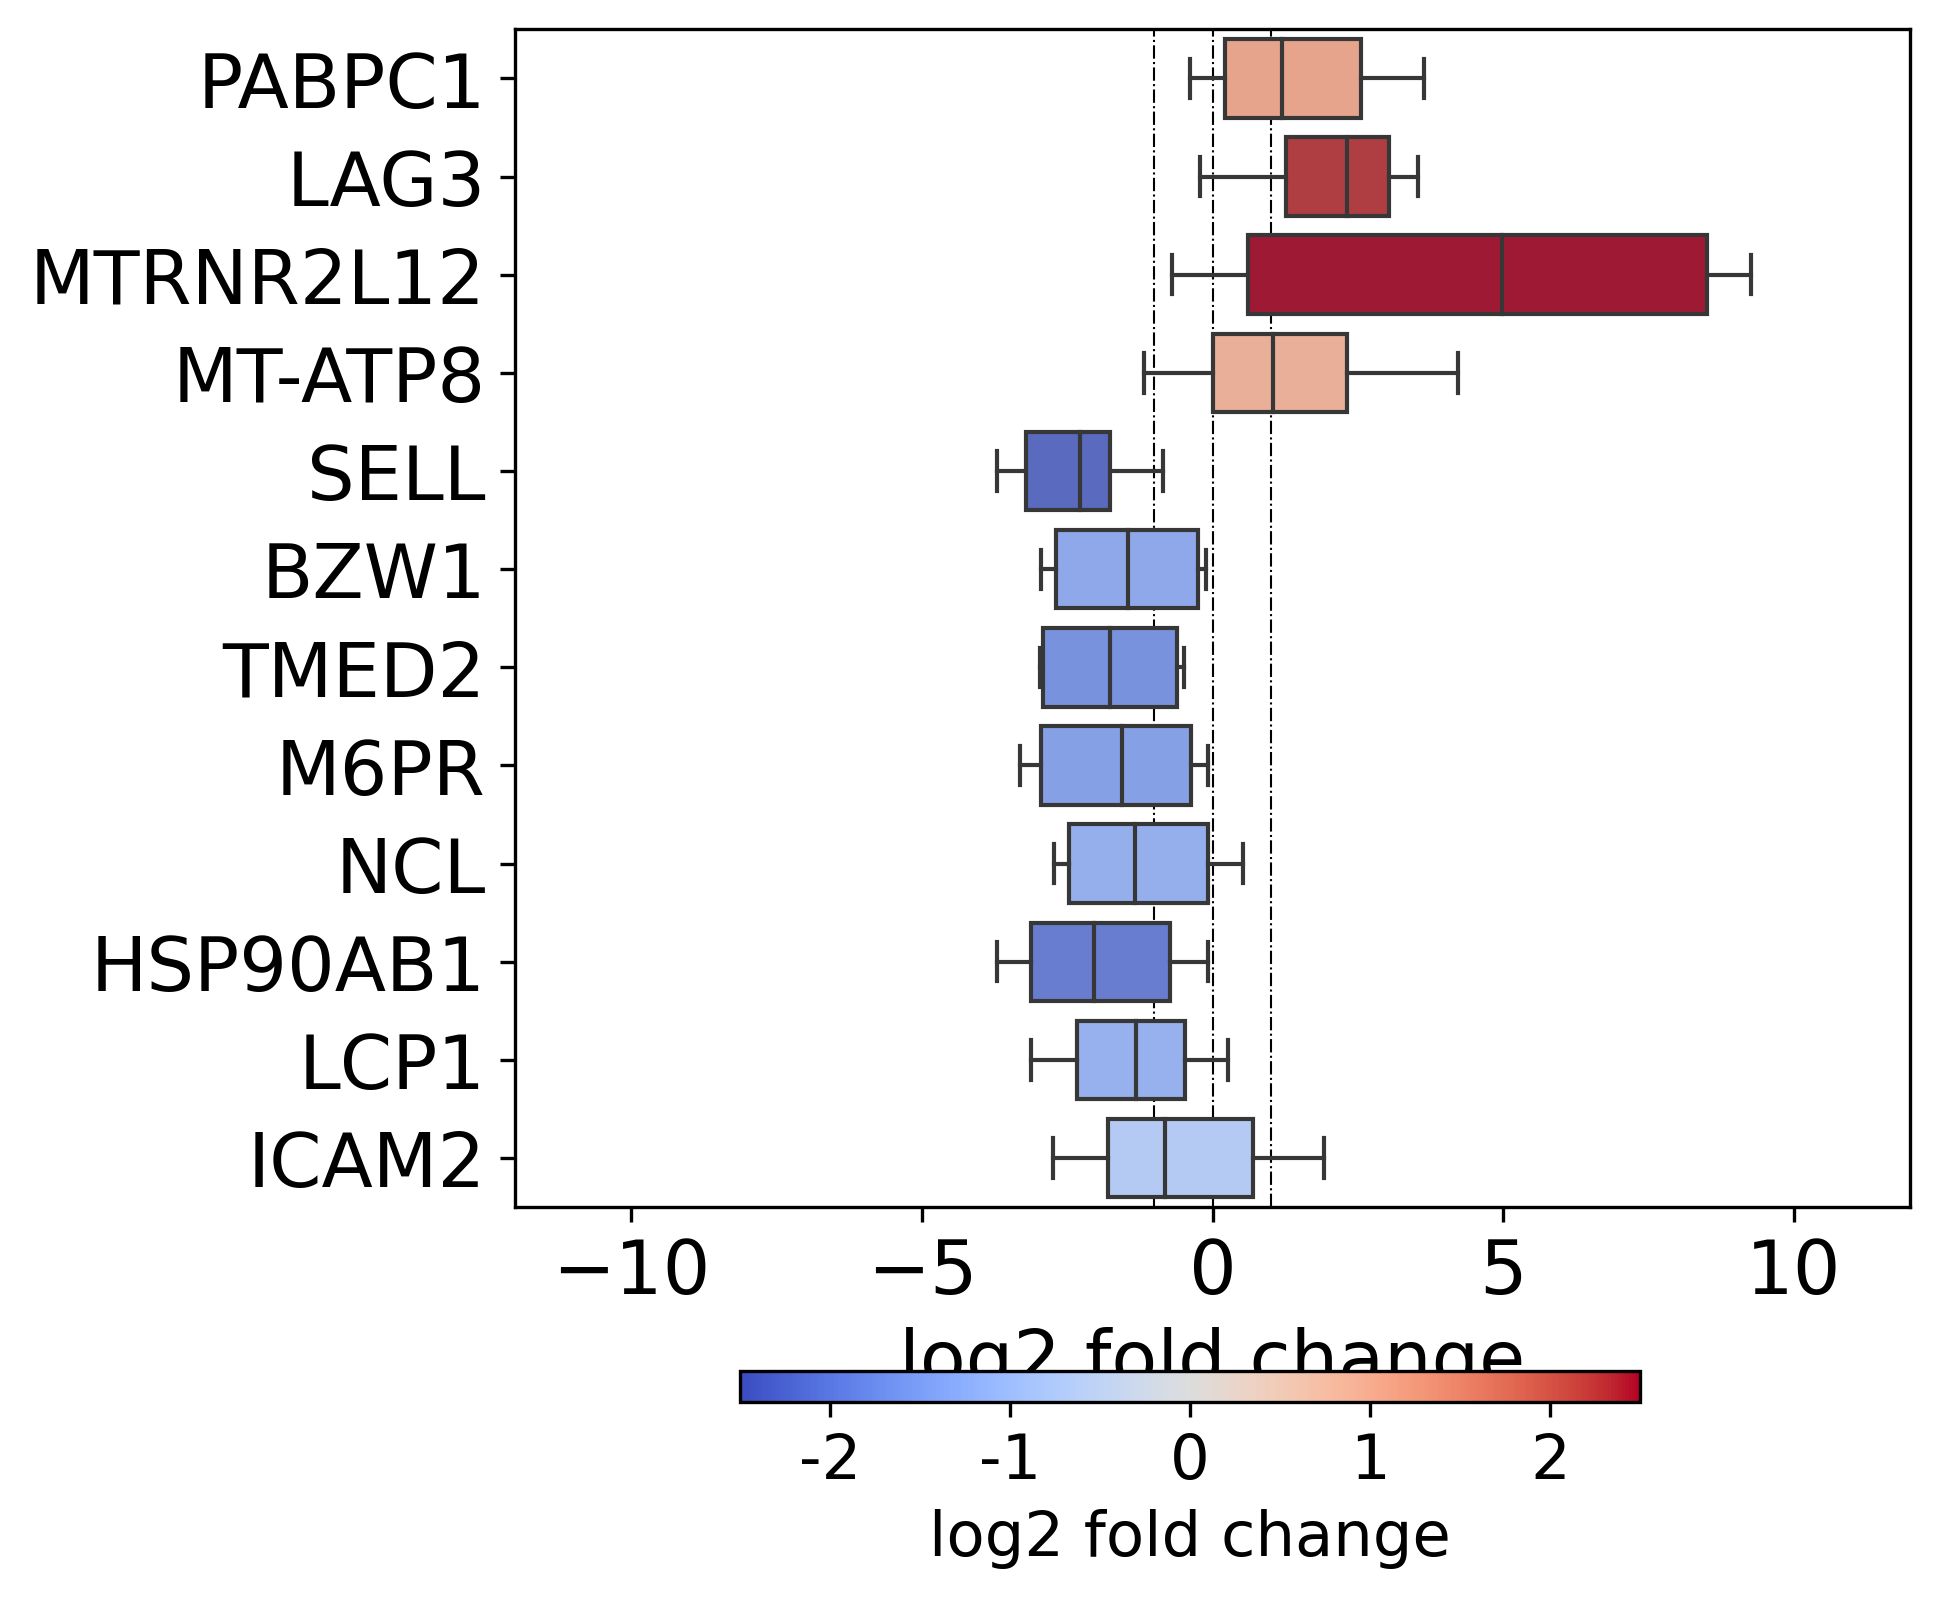

In [57]:
adult_genes = [
'PABPC1', 'LAG3', 'MTRNR2L12', 'MT-ATP8', 'SELL',
    'BZW1', 'TMED2', 'M6PR', 'NCL', 'HSP90AB1',
    'LCP1', 'ICAM2'
]
 
pairwise_boxplot(NK_cst_log2FC_a, ['cytotoxic NK cells'], adult_genes, path='NK_adult.pdf')
pairwise_boxplot(NK_cst_log2FC_a, ['cytotoxic NK cells'], adult_genes, path='NK_adult.png')